In [1]:
import os

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import spatial

from operator import itemgetter

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [2]:
print("Available devices: %s" % tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset

Dataset we're working with (https://www.kaggle.com/datasets/anokas/kuzushiji) contains handwritten Kanji (28x28 grayscale) and designed for a classification task. From the beginnig, we obrain already splitted dataset into its train and test parts with a file containing labels mapping to symbols, so we can visually confirm if image label/prediction is correct.

It is said that dataset is imbalanced. We confirmed this, so at first we rebalanced this dataset before going to the training process.

**NOTE**: Commented parts of the code were used before resampling, so they are not relevant for already preprocessed dataset.

In [24]:
os.listdir('datasets')

# X_train = np.load('datasets/k49-train-imgs.npz')['arr_0']
# Y_train = np.load('datasets/k49-train-labels.npz')['arr_0']

# X_test = np.load('datasets/k49-test-imgs.npz')['arr_0']
# Y_test = np.load('datasets/k49-test-labels.npz')['arr_0']
# balanced_data = np.load('datasets/resampled_dataset.npz')
balanced_data = np.load('datasets/resampled_dataset_2.npz')

X_train = balanced_data['X_train']
Y_train = balanced_data['Y_train']

X_test = balanced_data['X_test']
Y_test = balanced_data['Y_test']

label_map = pd.read_csv('datasets/k49_classmap.csv')

In [4]:
print(Y_test[:10])
print(label_map)

[19 23 10 31 26 12 24  9 24  8]
    index codepoint char
0       0    U+3042    あ
1       1    U+3044    い
2       2    U+3046    う
3       3    U+3048    え
4       4    U+304A    お
5       5    U+304B    か
6       6    U+304D    き
7       7    U+304F    く
8       8    U+3051    け
9       9    U+3053    こ
10     10    U+3055    さ
11     11    U+3057    し
12     12    U+3059    す
13     13    U+305B    せ
14     14    U+305D    そ
15     15    U+305F    た
16     16    U+3061    ち
17     17    U+3064    つ
18     18    U+3066    て
19     19    U+3068    と
20     20    U+306A    な
21     21    U+306B    に
22     22    U+306C    ぬ
23     23    U+306D    ね
24     24    U+306E    の
25     25    U+306F    は
26     26    U+3072    ひ
27     27    U+3075    ふ
28     28    U+3078    へ
29     29    U+307B    ほ
30     30    U+307E    ま
31     31    U+307F    み
32     32    U+3080    む
33     33    U+3081    め
34     34    U+3082    も
35     35    U+3084    や
36     36    U+3086    ゆ
37     37    U+308

Here can be seen an example of images we're working with

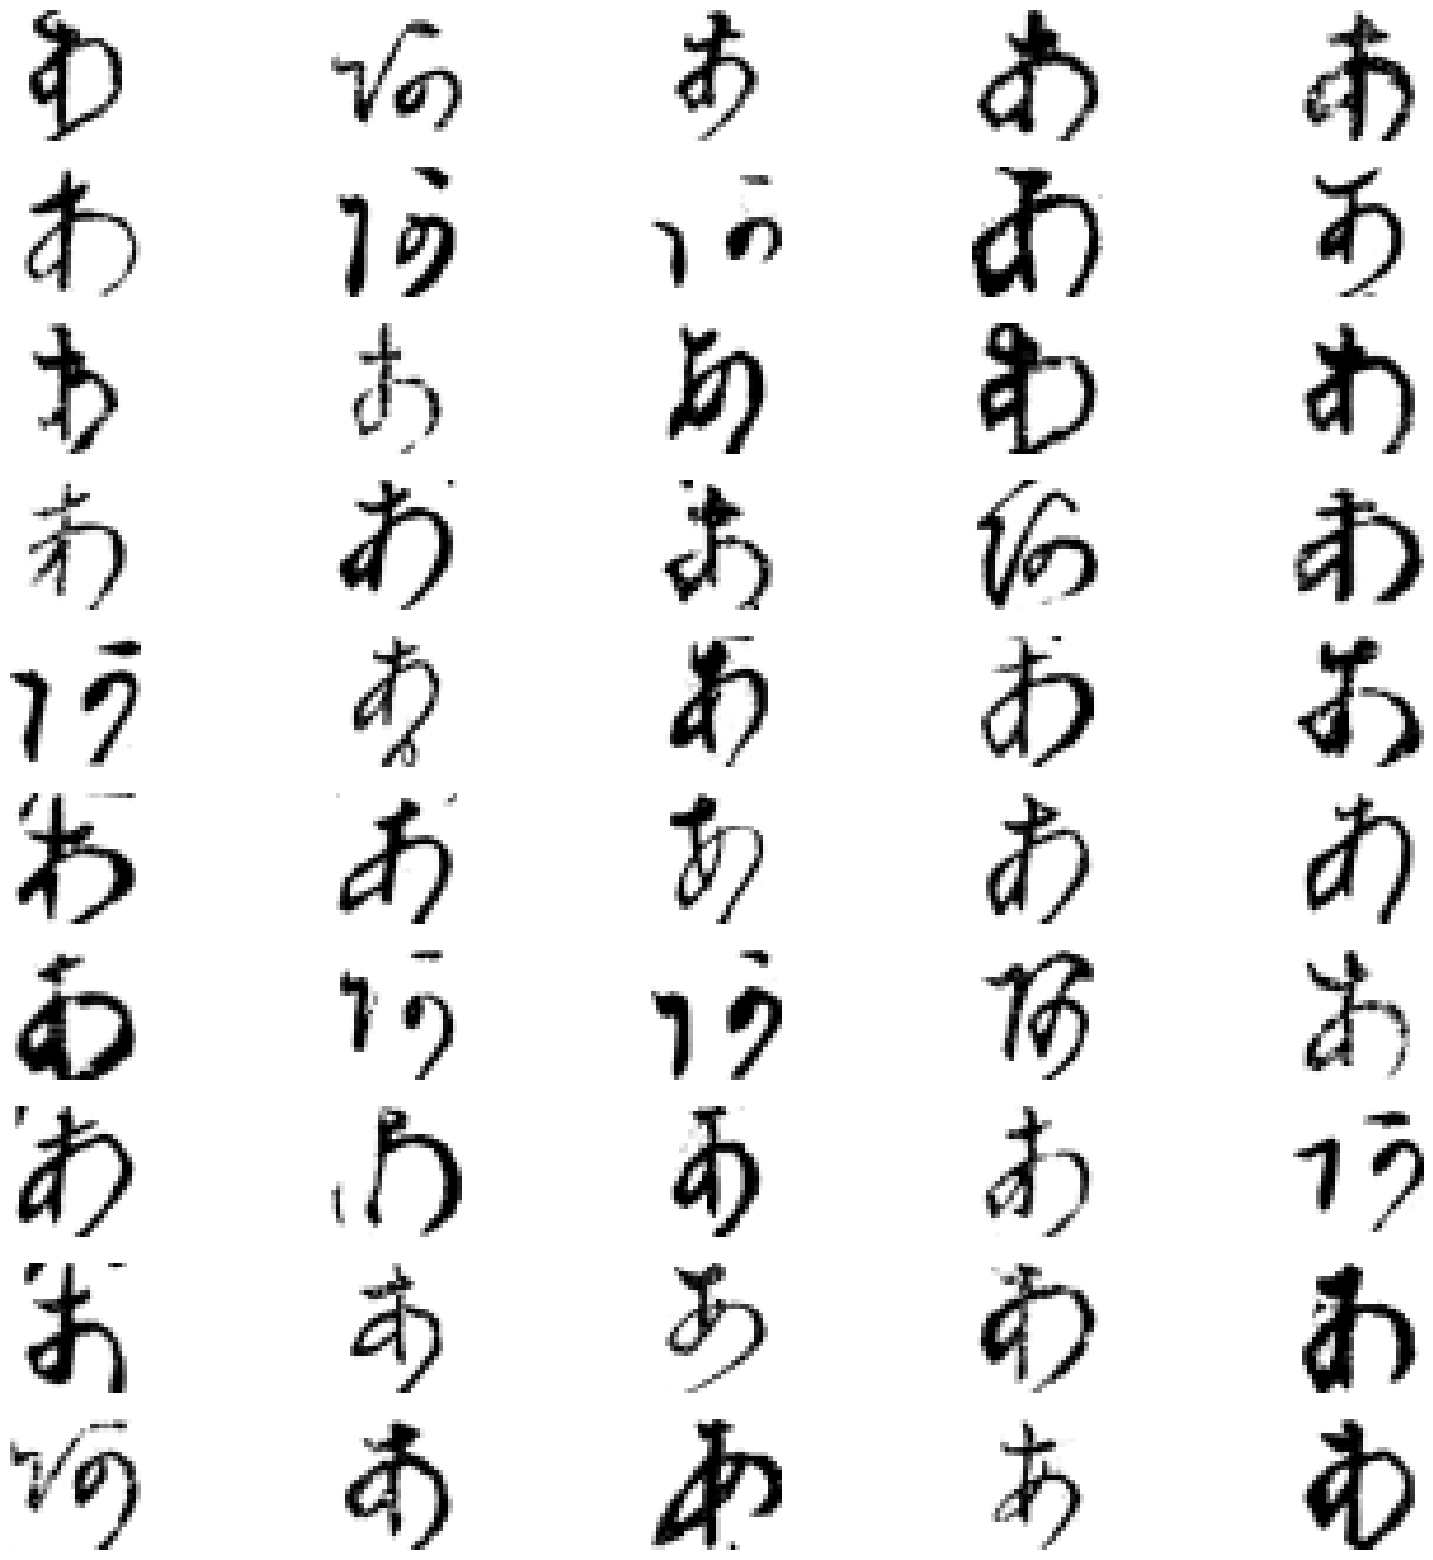

In [5]:
plt.figure(figsize=(20,20))
for i in range(0,50) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X_train[1000+i].reshape(28,28), cmap="gray_r")

In [6]:
print(f"""
Train set dimensions: {X_train.shape}, {Y_train.shape}
Test set dimensions: {X_test.shape}, {Y_test.shape}
""")


Train set dimensions: (235200, 28, 28, 1), (235200,)
Test set dimensions: (38547, 28, 28, 1), (38547,)



## Dataset balancing and augmentation

**NOTE**: Some code block are commented because they have been used in the dataset rebalancing process. They (code blocks) will not be reused in the training, since the rebalanced dataset will be used since then

In [7]:
# # reshape data
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) / 255
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) / 255

Right now, after dataset rebalancing, all classes are totally equal in size. 

To achieve this, we have generated 400 augmented images for each class with les than 2000 samples. It was done to preserve original data, since augmented may be not totally correct and big amount of them may lead to inconsistent Kanji shapes and have a huge negative impact on a result.

After minor classes were extended we upsampled them up to 80% of the major classes. And then all major classes were downsampled by 20%. This way we do not have too many similar data in each class, and managed to preserve enough images to train NN.

In [8]:
unique_labels = np.unique(Y_train)

# count the number of samples of classes in 'Y_train'
for label in unique_labels:
    count = np.sum(Y_train == label)
    print("Label {}: {} samples".format(label, count))

Label 0: 4800 samples
Label 1: 4800 samples
Label 2: 4800 samples
Label 3: 4800 samples
Label 4: 4800 samples
Label 5: 4800 samples
Label 6: 4800 samples
Label 7: 4800 samples
Label 8: 4800 samples
Label 9: 4800 samples
Label 10: 4800 samples
Label 11: 4800 samples
Label 12: 4800 samples
Label 13: 4800 samples
Label 14: 4800 samples
Label 15: 4800 samples
Label 16: 4800 samples
Label 17: 4800 samples
Label 18: 4800 samples
Label 19: 4800 samples
Label 20: 4800 samples
Label 21: 4800 samples
Label 22: 4800 samples
Label 23: 4800 samples
Label 24: 4800 samples
Label 25: 4800 samples
Label 26: 4800 samples
Label 27: 4800 samples
Label 28: 4800 samples
Label 29: 4800 samples
Label 30: 4800 samples
Label 31: 4800 samples
Label 32: 4800 samples
Label 33: 4800 samples
Label 34: 4800 samples
Label 35: 4800 samples
Label 36: 4800 samples
Label 37: 4800 samples
Label 38: 4800 samples
Label 39: 4800 samples
Label 40: 4800 samples
Label 41: 4800 samples
Label 42: 4800 samples
Label 43: 4800 sample

Since we're woking with small (28x28x1) graysclade images containing hadwritten kanji, we can't apply horizontal or vertical flip, as well as a big rotation rotation (40+ degrees). It is because kanji are always written in the similar form and position, and definitely are not rotated or flipped any way.

That's why we decided to use horizontal/vertical shift equal to 10% of image size (~3 pixels) as well as zooming (10%). These transformations definitely will retain original kanji shape even if it is a bit shifted, zoomed in, or rotated a bit (10 degrees).

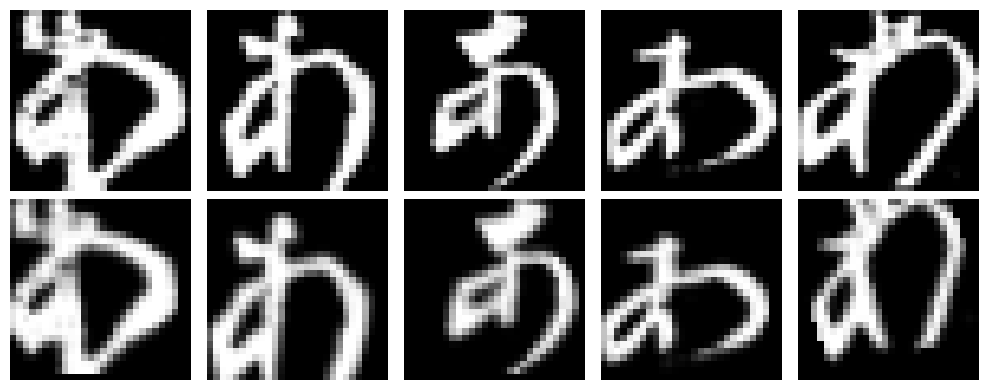

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
        width_shift_range=0.1,  # shift the image horizontally by 20% of the width
        height_shift_range=0.1,  # shift the image vertically by 20% of the height
        rotation_range=20,  # rotate the image by 20 degrees
        zoom_range=0.1,  # zoom in or out of the image by 20%
        fill_mode='constant',  # fill any new pixels with the nearest pixel value
        cval=0
)

# # create a generator to generate augmented images from the in-memory images
# image_generator = datagen.flow(X_train, batch_size=1)

# plot some of the generated images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(5):
    aug_image = datagen.random_transform(
        X_train[i], seed=i
    )
    axs[i].imshow(X_train[i].squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i+5].imshow(aug_image.squeeze(), cmap='gray')
    axs[i+5].axis('off')
    
plt.tight_layout()
plt.show()

In [10]:
# # add 0.1% of augmented data to the training dataset
# for i in tqdm(range(int(len(X_train)/1000)), ncols=100):
#     aug_image = datagen.random_transform(
#         X_train[i], seed=i
#     )
#     # append the new image to X_train
#     X_train = np.concatenate([X_train, np.expand_dims(aug_image, axis=0)])
#     # append the corresponding label to Y_train
#     Y_train = np.concatenate([Y_train, np.expand_dims(Y_train[i], axis=0)])

In [11]:
# from collections import defaultdict

# # count the number of samples for each class
# label_counts = defaultdict(int)
# for label in Y_train:
#     label_counts[label] += 1

# # augment the samples for labels with less than 2000 samples
# for label in np.unique(Y_train):
#     count = label_counts[label]
#     if count < 2000:
#         print("Label {}: {} samples".format(label, count))
#         # select 400 samples to augment
#         indices = np.where(Y_train == label)[0]
#         n_samples = min(400, count) # for classes with less than 400 items
#         selected_indices = np.random.choice(indices, n_samples, replace=False)
#         # augment the selected samples and append to X_train and Y_train
#         for i in tqdm(selected_indices, ncols=100):
#             aug_image = datagen.random_transform(X_train[i], seed=i)
#             X_train = np.concatenate([X_train, np.expand_dims(aug_image, axis=0)])
#             Y_train = np.concatenate([Y_train, np.expand_dims(Y_train[i], axis=0)])

In [12]:
# # pip install imbalanced-learn
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter

# # set up strategy for oversampling - up to 80% of major classes

# # count the number of samples for each class
# class_counts = np.bincount(Y_train)
# # determine the majority and minority classes
# majority_class = np.argmax(class_counts)
# minority_classes = np.where(class_counts < 0.8 * np.max(class_counts))[0]
# print(majority_class, minority_classes)

# sampling_strategy = {label: int(0.8 * class_counts[majority_class]) for label in minority_classes}

# # init sampling methods
# oversampler = SMOTE(sampling_strategy=sampling_strategy)
# undersampler = RandomUnderSampler()

# # pipline: oversample minors up to 80% of majors -> undersample majors
# pipeline = Pipeline(steps=[('over', oversampler), ('under', undersampler)])


# X_train = X_train.reshape(X_train.shape[0], -1)

# # resample the training data using the pipeline
# X_train, Y_train = pipeline.fit_resample(X_train, Y_train)


# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

# print('Resampled training dataset:', Counter(Y_train))

In [13]:
# # Save datasets to .npz file
# np.savez('datasets/resampled_dataset_2.npz', X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

In [27]:
# split data
num_class = len(np.unique(Y_train))

Y_train = to_categorical(Y_train, num_class)
Y_test = to_categorical(Y_test, num_class)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.2, random_state = 100)

In [28]:
print(f"""
Train set dimensions: {X_train.shape}, {Y_train.shape}
Test set dimensions: {X_test.shape}, {Y_test.shape}
Validation set dimensions: {X_val.shape}, {Y_val.shape}
""")


Train set dimensions: (235200, 28, 28, 1), (235200, 49)
Test set dimensions: (30837, 28, 28, 1), (30837, 49)
Validation set dimensions: (7710, 28, 28, 1), (7710, 49)



## NN definition

Our NN consists of 3 CNN layers, MaxPooling, Normalization, Dropout and Dense layers.

CNN layers filters number is increasing with each layer, while filter size is reducing. It is done to capture "general" features in the beginning of the training, and then detect multiple smaller. Since images are mostly "black", we're not interested in background, but only in edges of symbols.

Dropout has been added to avoid overfitting, since after data augmentation there are a lot of similar Kanji and similar images.

Dense layers process extracted features in the end and return label of the classified image.

In [16]:
def build_model(filter_count, dropout, optimizer_name, learning_rate):
    model = Sequential()
    # First convolution
    model.add(Conv2D(filter_count,(7,7),activation = 'relu', input_shape = (28,28,1), padding="same"))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    # Second convolution
    model.add(Conv2D(filter_count * 2,(5,5),activation = 'relu'))
    # Third convolution
    model.add(Conv2D(filter_count * 4,(3,3),activation = 'relu'))
    model.add(Flatten())
    # Feature extracture
    model.add(Dense(filter_count * 4,activation = 'relu'))
    model.add(Dropout(dropout))
    # Output layer
    model.add(Dense(num_class,activation = 'softmax', kernel_regularizer='l2'))

#     model.summary()

    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_name == "Nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

Additionaly, to make sure there will be no overfitted models and to reduce training time, early stopping has been used. It was set to stop model training if validation loss value has not become better after 2 epochs in a row.

In [25]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping

# set up early stopping to avoid overfitting
# stop run if there is no val_loss improvement over 2 epochs
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=2)

def train():
    # default hyperparameters
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 10,
        'filter_count': 4,
        'batch_size': 64,
        'dropout': 0.2,
        'optimizer': 'Adam'
    }
    wandb.init(config=config_defaults)
    
    wandb_cb = WandbCallback()

    # configure the model
    config = wandb.config
    with strategy.scope():
        model = build_model(config.filter_count, config.dropout, config.optimizer, config.learning_rate)
        
        # train the model
        history = model.fit(X_train, Y_train,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    verbose = 0,
                    validation_data = (X_val,Y_val),
                    callbacks=[
                        early_stop,
                        wandb_cb
                    ])
    

    # log the results
    metrics = {
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1]
    }
    # wandb.log(metrics)
    print(config)

We decided to tune the following hyperparameters:

    1) number of filters in the CNN layer
    2) learning rate of the chosen optimizer
    3) dropout rate
    4) batch size
    5) number of epochs
    6) optimizer (Adam, Nadam, RMSprop)
    
In the training model was trying to adapt these hyperparameters to maximize validation accuracy value, since it shows how good this model is in prediction of new Kanji.

In [18]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'filter_count': {
            'values': [8, 16, 32, 64]
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.001
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4, 0.5, 0.6]
        },
        'batch_size': {
            'values': [64, 128]
        },
        'epochs': {
            'values': [30]
        },
        'optimizer': {
            'values': ['Nadam', 'Adam', 'RMSprop']
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb.agent(sweep_id, function=train, count=15)

Create sweep with ID: 39avbttr
Sweep URL: https://wandb.ai/xkretinin/uncategorized/sweeps/39avbttr


wandb: Agent Starting Run: 0b9gdcto with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 30
wandb: 	filter_count: 16
wandb: 	learning_rate: 0.000374223703644744
wandb: 	optimizer: Nadam
wandb: Currently logged in as: xkretinin. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210329-0b9gdcto\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.5, 'epochs': 30, 'filter_count': 16, 'learning_rate': 0.000374223703644744, 'optimizer': 'Nadam'}


accuracy,▁▅▆▇▇▇██████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▄▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁▁▁
accuracy,0.92762
best_epoch,9
best_val_loss,0.35358
epoch,11
loss,0.28083
val_accuracy,0.91375


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m0bdu0sm with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.6
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0004859418232630682
wandb: 	optimizer: RMSprop


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210546-m0bdu0sm\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210546-m0bdu0sm\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210546-m0bdu0sm\files\model-best)... Done. 0.1s


{'batch_size': 64, 'dropout': 0.6, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0004859418232630682, 'optimizer': 'RMSprop'}


accuracy,▁██
epoch,▁▅█
loss,█▁▂
val_accuracy,▁▇█
val_loss,▁▆█
accuracy,0.93625
best_epoch,0
best_val_loss,0.52879
epoch,2
loss,0.46538
val_accuracy,0.91686


wandb: Agent Starting Run: u9yed844 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.6
wandb: 	epochs: 30
wandb: 	filter_count: 8
wandb: 	learning_rate: 0.00017704961223646251
wandb: 	optimizer: Nadam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_210706-u9yed844\files\model-best)... Done. 0.0s


{'batch_size': 64, 'dropout': 0.6, 'epochs': 30, 'filter_count': 8, 'learning_rate': 0.00017704961223646251, 'optimizer': 'Nadam'}


accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇███████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.67671
best_epoch,29
best_val_loss,0.73928
epoch,29
loss,1.09129
val_accuracy,0.8201


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rtcxt10a with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 30
wandb: 	filter_count: 32
wandb: 	learning_rate: 0.0003918073816892067
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211539-rtcxt10a\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.5, 'epochs': 30, 'filter_count': 32, 'learning_rate': 0.0003918073816892067, 'optimizer': 'Adam'}


accuracy,▁▆▆▇▇▇▇██████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇▇█████
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▂
accuracy,0.9736
best_epoch,10
best_val_loss,0.25433
epoch,12
loss,0.10932
val_accuracy,0.9454


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7k89eyc0 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0003626472578939376
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_211804-7k89eyc0\files\model-best)... Done. 0.1s


{'batch_size': 128, 'dropout': 0.5, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0003626472578939376, 'optimizer': 'Adam'}


accuracy,▁▆▇▇██
epoch,▁▂▄▅▇█
loss,█▃▂▁▁▁
val_accuracy,▁▅▇███
val_loss,█▃▂▁▁▁
accuracy,0.97579
best_epoch,3
best_val_loss,0.24926
epoch,5
loss,0.10986
val_accuracy,0.94656


wandb: Agent Starting Run: es1lao64 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.000792033435642066
wandb: 	optimizer: RMSprop


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212101-es1lao64\files\model-best)... Done. 0.1s


{'batch_size': 128, 'dropout': 0.3, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.000792033435642066, 'optimizer': 'RMSprop'}


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_accuracy,▁▆▆██
val_loss,▆▁▁▇█
accuracy,0.97023
best_epoch,2
best_val_loss,0.35632
epoch,4
loss,0.16174
val_accuracy,0.93372


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t37di47e with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.6
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.000649841961766052
wandb: 	optimizer: RMSprop


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212301-t37di47e\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212301-t37di47e\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212301-t37di47e\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212301-t37di47e\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212301-t37di47e\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212301-t37di47e\files\model-best)... Done. 0.1s


{'batch_size': 128, 'dropout': 0.6, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.000649841961766052, 'optimizer': 'RMSprop'}


accuracy,▁▇██
epoch,▁▃▆█
loss,█▁▁▁
val_accuracy,▁▇▇█
val_loss,█▁▃▅
accuracy,0.95202
best_epoch,1
best_val_loss,0.41411
epoch,3
loss,0.30088
val_accuracy,0.93204


wandb: Agent Starting Run: toxqb7e6 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0003700207460124089
wandb: 	optimizer: RMSprop


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212436-toxqb7e6\files\model-best)... Done. 0.2s


{'batch_size': 128, 'dropout': 0.4, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0003700207460124089, 'optimizer': 'RMSprop'}


accuracy,▁▇▇███
epoch,▁▂▄▅▇█
loss,█▂▁▁▁▁
val_accuracy,▁▆▇██▇
val_loss,█▂▁▁▂▁
accuracy,0.97339
best_epoch,3
best_val_loss,0.30512
epoch,5
loss,0.15894
val_accuracy,0.94086


wandb: Agent Starting Run: 0ksbnevq with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0006383225031689533
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212649-0ksbnevq\files\model-best)... Done. 0.2s


{'batch_size': 128, 'dropout': 0.2, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0006383225031689533, 'optimizer': 'Adam'}


accuracy,▁▆▇▇██
epoch,▁▂▄▅▇█
loss,█▃▂▁▁▁
val_accuracy,▁▄▅██▇
val_loss,█▄▄▁▃▃
accuracy,0.98303
best_epoch,3
best_val_loss,0.27117
epoch,5
loss,0.08068
val_accuracy,0.94319


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sjs8buzw with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0009437039559575476
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_212951-sjs8buzw\files\model-best)... Done. 0.2s


{'batch_size': 128, 'dropout': 0.4, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0009437039559575476, 'optimizer': 'Adam'}


accuracy,▁▆▇▇███
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
val_accuracy,▁▃▇▆▇▇█
val_loss,█▅▁▂▁▃▂
accuracy,0.97672
best_epoch,4
best_val_loss,0.31227
epoch,6
loss,0.11542
val_accuracy,0.94371


wandb: Agent Starting Run: l0ybu0fv with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filter_count: 32
wandb: 	learning_rate: 0.0008152618930564044
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213246-l0ybu0fv\files\model-best)... Done. 0.1s


{'batch_size': 128, 'dropout': 0.2, 'epochs': 30, 'filter_count': 32, 'learning_rate': 0.0008152618930564044, 'optimizer': 'Adam'}


accuracy,▁▆▇▇███
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
val_accuracy,▁▁▆▇█▇█
val_loss,█▆▂▂▁▂▂
accuracy,0.9772
best_epoch,4
best_val_loss,0.29283
epoch,6
loss,0.09958
val_accuracy,0.93813


wandb: Agent Starting Run: jhrszg56 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.00029237300175983036
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213404-jhrszg56\files\model-best)... Done. 0.1s


{'batch_size': 128, 'dropout': 0.2, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.00029237300175983036, 'optimizer': 'Adam'}


accuracy,▁▆▇▇██
epoch,▁▂▄▅▇█
loss,█▃▂▁▁▁
val_accuracy,▁▅▇▇██
val_loss,█▃▂▁▁▁
accuracy,0.98492
best_epoch,3
best_val_loss,0.24617
epoch,5
loss,0.06763
val_accuracy,0.94786


wandb: Agent Starting Run: 56ewea32 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0009134093084232344
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213658-56ewea32\files\model-best)... Done. 0.2s


{'batch_size': 128, 'dropout': 0.2, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0009134093084232344, 'optimizer': 'Adam'}


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▇██▇
val_loss,█▂▁▂▃
accuracy,0.97767
best_epoch,2
best_val_loss,0.28711
epoch,4
loss,0.1079
val_accuracy,0.93463


wandb: Agent Starting Run: e5tmtvov with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0009730043823302976
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_213926-e5tmtvov\files\model-best)... Done. 0.2s


{'batch_size': 128, 'dropout': 0.3, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0009730043823302976, 'optimizer': 'Adam'}


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▁▂▃
accuracy,0.97534
best_epoch,2
best_val_loss,0.28941
epoch,4
loss,0.12151
val_accuracy,0.94099


wandb: Agent Starting Run: rbiphio9 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filter_count: 64
wandb: 	learning_rate: 0.0004071551474153743
wandb: 	optimizer: Adam


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_214154-rbiphio9\files\model-best)... Done. 0.2s


{'batch_size': 128, 'dropout': 0.2, 'epochs': 30, 'filter_count': 64, 'learning_rate': 0.0004071551474153743, 'optimizer': 'Adam'}


accuracy,▁▆▇▇███
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
val_accuracy,▁▆▆▇█▇▇
val_loss,█▂▁▁▁▁▄
accuracy,0.9871
best_epoch,4
best_val_loss,0.26002
epoch,6
loss,0.06075
val_accuracy,0.94565


Sweep process and results can be seen in the following report:
https://api.wandb.ai/links/xkretinin/uh2uj2e3

In [19]:
# sweep_obj = wandb.Api().sweep('peter-kudela/uncategorized/sweeps/' + sweep_id)
sweep_obj = wandb.Api().sweep('xkretinin/uncategorized/sweeps/' + sweep_id)
best_config = sweep_obj.best_run().config

print("Best run config:")
print(best_config)
print(f"Validation accuracy: {sweep_obj.best_run().summary['val_accuracy']}")

wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy


Best run config:
{'epochs': 30, 'dropout': 0.2, 'optimizer': 'Adam', 'batch_size': 128, 'filter_count': 64, 'learning_rate': 0.00029237300175983036}
Validation accuracy: 0.9478599429130554


In [29]:
model = build_model(best_config['filter_count'], best_config['dropout'], best_config['optimizer'], best_config['learning_rate'])
history = model.fit(X_train, Y_train,
                    epochs=best_config['epochs'],
                    batch_size=best_config['batch_size'],
                    verbose = 1,
                    validation_data = (X_val,Y_val),
                    callbacks=[
                        early_stop,
                    ])

Epoch 1/30
1838/1838 [==============================] - 16s 9ms/step - loss: 0.6538 - accuracy: 0.8957 - val_loss: 0.4067 - val_accuracy: 0.9219
Epoch 2/30
1838/1838 [==============================] - 16s 9ms/step - loss: 0.2101 - accuracy: 0.9609 - val_loss: 0.3127 - val_accuracy: 0.9302
Epoch 3/30
1838/1838 [==============================] - 15s 8ms/step - loss: 0.1370 - accuracy: 0.9716 - val_loss: 0.2627 - val_accuracy: 0.9415
Epoch 4/30
1838/1838 [==============================] - 15s 8ms/step - loss: 0.1048 - accuracy: 0.9772 - val_loss: 0.2652 - val_accuracy: 0.9409
Epoch 5/30
1838/1838 [==============================] - 15s 8ms/step - loss: 0.0838 - accuracy: 0.9816 - val_loss: 0.2598 - val_accuracy: 0.9436
Epoch 6/30
1838/1838 [==============================] - 15s 8ms/step - loss: 0.0704 - accuracy: 0.9842 - val_loss: 0.2526 - val_accuracy: 0.9494
Epoch 7/30
1838/1838 [==============================] - 16s 9ms/step - loss: 0.0600 - accuracy: 0.9868 - val_loss: 0.2650 - val_ac

As can be seen, model training has been stropped earlier due to the possible overfitting. However, model, trained on the best config of the executed sweep, managed to achieve 95% accuracy on validation data, which can be considered as a good result.

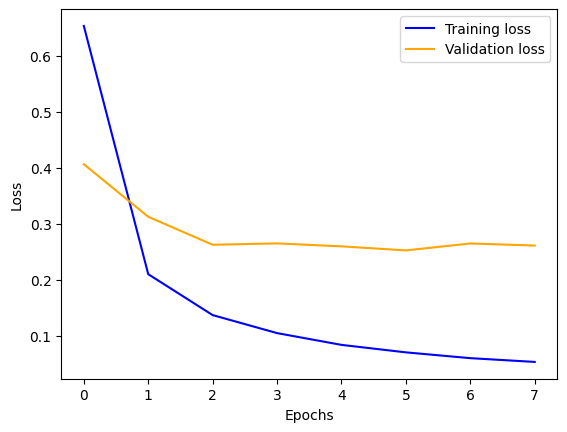

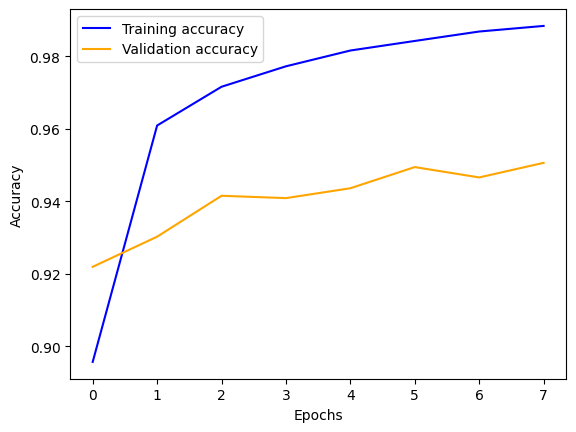

In [30]:
plt.plot(history.history['loss'], label = 'Training loss', color = 'blue')
plt.plot(history.history['val_loss'], label = 'Validation loss', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'], label = 'Training accuracy', color = 'blue')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Prediction

To test the model we have selected 100 images from the testing dataset. This dataset has not been augmentated, so all data are original. Model has managed to predict correctly **97 Kanji out of 100**, what confirms our val_accuracy metric value obtained from training process.

In [22]:
def get_kanji_by_idx(idx):
    return label_map[label_map['index'] == idx]['char'].values[0]

In [23]:
import random
history.history

print("Evaluate model on test data")
results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

idxs = []

for i in range(100):
    idxs.append(random.randint(1, len(X_test)))
    
prediction = model.predict(X_test[idxs])
print("prediction shape:", prediction.shape)

for i in range(len(prediction)):
    pred_idx = np.argmax(prediction[i])
    true_idx = np.argmax(Y_test[idxs[i]])
    if pred_idx != true_idx:
        print(f"{i}: Predicted {get_kanji_by_idx(pred_idx)} / Original {get_kanji_by_idx(true_idx)}")

Evaluate model on test data
241/241 [==============================] - 1s 3ms/step - loss: 0.3225 - accuracy: 0.9528
test loss, test acc: [0.3225458264350891, 0.9527515769004822]
4/4 [==============================] - 0s 13ms/step
prediction shape: (100, 49)
61: Predicted れ / Original ね
78: Predicted な / Original を
88: Predicted に / Original て
